In [184]:
import os
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import wasserstein_distance as wass1
from scipy.stats import ks_2samp

import randomly
import gc

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import LassoLarsIC, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut

In [2]:
os.chdir('/media/bramiozo/DATA-FAST/genetic_expression/cxb')

In [3]:
counts = dict()
counts['genes'] = pd.read_csv("cuffnorm_out/genes.count_table", sep="\t")
counts['genes'].set_index('tracking_id', inplace=True)

In [4]:
# remove all zero rows
keep_rows = counts['genes'].index[(counts['genes'].std(axis=1)!=0) & (counts['genes'].mean(axis=1)!=0)]
counts['genes'] = counts['genes'].loc[keep_rows]

In [5]:
counts['genes']['median_expr'] = counts['genes'].median(axis=1)
counts['genes']['mean_expr'] = counts['genes'].mean(axis=1)
counts['genes']['std_expr'] = counts['genes'].std(axis=1)


In [ ]:
counts['genes_attr'] = pd.read_csv("cuffnorm_out/genes.attr_table", sep="\t")
gene_xloc = counts['genes_attr'][['tracking_id', 'gene_short_name']]
gene_xloc.set_index('tracking_id', inplace=True)

# Univariate differential analysis

Combination of 1st Wasserstein distance, Kolmogorov-Smirnov statistics and the $\Delta median$

## Gene raw count

In [6]:
responders = [c for c in counts['genes'].columns if c[:8]=='response']
non_responders = [c for c in counts['genes'].columns if c[:3]=='non']
def get_wasserstein(x):
    xr = x[responders]
    xnr =  x[non_responders]
    return wass1(xr, xnr)

counts['genes']['MedianDiff_r2nr'] = counts['genes'][responders].median(axis=1) - counts['genes'][non_responders].median(axis=1)

In [7]:
counts['genes']['MedianDiff_r2nr_reltoSTD'] = counts['genes']['MedianDiff_r2nr']/counts['genes']['std_expr']

In [8]:
counts['genes']['wasserstein_1_r2nr'] = counts['genes'].apply(get_wasserstein, axis=1)
counts['genes']['wasserstein_1_r2nr_reltoMean'] = counts['genes']['wasserstein_1_r2nr']/counts['genes']['mean_expr']
counts['genes']['wasserstein_1_r2nr_reltoSTD'] = counts['genes']['wasserstein_1_r2nr']/counts['genes']['std_expr']

In [9]:
def get_ks(x):
    xr = x[responders]
    xnr =  x[non_responders]
    ksr = ks_2samp(xr, xnr)
    return pd.Series({'ks_dist': ksr[0], 'ks_pval': ksr[1]})

In [10]:
counts['genes'][['ks_dist', 'ks_pval']] = counts['genes'].apply(get_ks, axis=1)

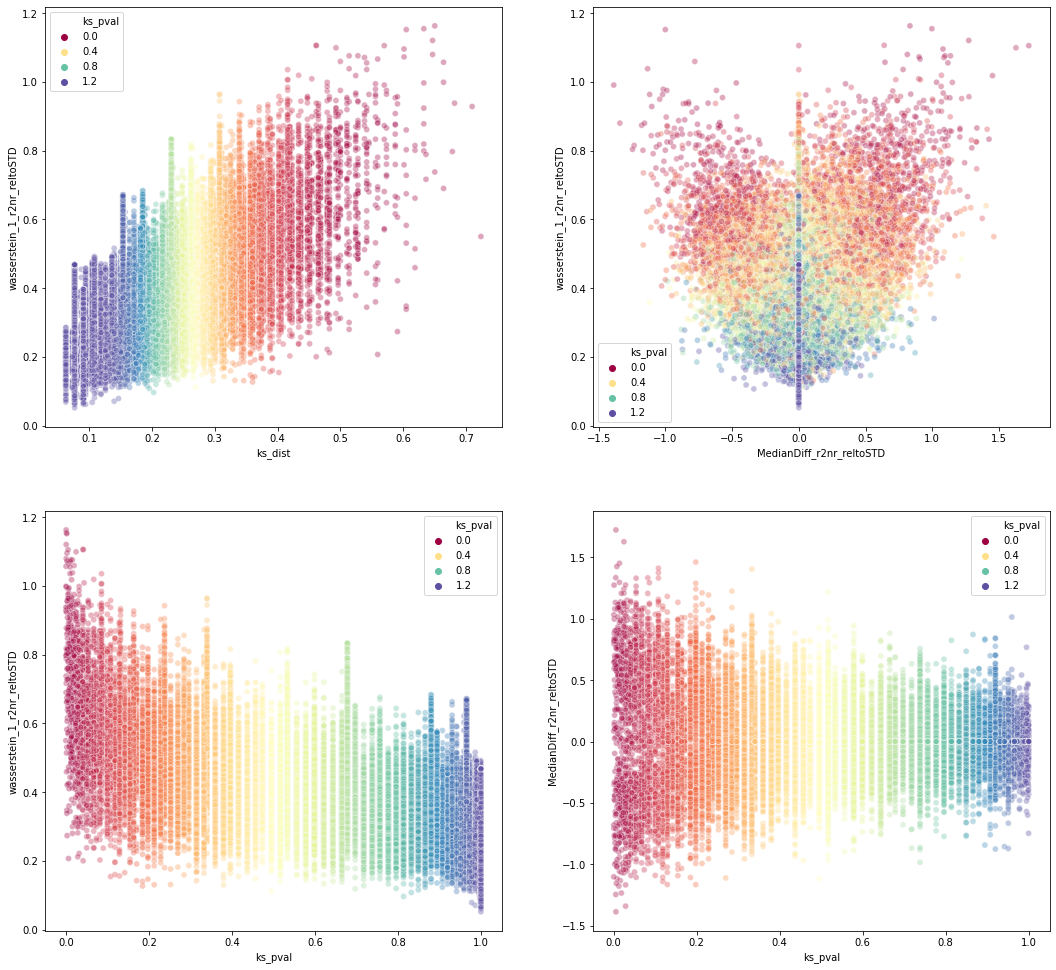

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,17))

max_p = 1
max_pval = counts['genes'].loc[counts['genes'].ks_pval<max_p].index

sns.scatterplot(data=counts['genes'].loc[max_pval, ['ks_pval', 'ks_dist', 'wasserstein_1_r2nr_reltoSTD']],
              x='ks_dist', y='wasserstein_1_r2nr_reltoSTD', hue='ks_pval', alpha=0.35,
                palette='Spectral', ax=ax[0,0])

sns.scatterplot(data=counts['genes'].loc[max_pval,['ks_pval', 'ks_dist', 'wasserstein_1_r2nr_reltoSTD', 
                                      'MedianDiff_r2nr', 'mean_expr', 'MedianDiff_r2nr_reltoSTD']],
              x='MedianDiff_r2nr_reltoSTD', y='wasserstein_1_r2nr_reltoSTD', hue='ks_pval', alpha=0.35,
                palette='Spectral', ax=ax[0,1])

sns.scatterplot(data=counts['genes'].loc[max_pval, ['ks_pval', 'ks_dist', 'wasserstein_1_r2nr_reltoSTD']],
              x='ks_pval', y='wasserstein_1_r2nr_reltoSTD', hue='ks_pval', alpha=0.35,
                palette='Spectral', ax=ax[1,0])

sns.scatterplot(data=counts['genes'].loc[max_pval,['ks_pval', 'ks_dist', 'wasserstein_1_r2nr_reltoSTD', 
                                      'MedianDiff_r2nr', 'mean_expr', 'MedianDiff_r2nr_reltoSTD']],
              y='MedianDiff_r2nr_reltoSTD', x='ks_pval', hue='ks_pval', alpha=0.35,
                palette='Spectral', ax=ax[1,1])


In [12]:
gc.collect()

30

## Wasserstein based list

In [114]:
CUST_filtered = counts['genes'].loc[counts['genes'].wasserstein_1_r2nr_reltoSTD>0.9]

## Logistic Regressor with L1

In [282]:
LR = LogisticRegressionCV(cv=20, penalty='l1', solver='liblinear', max_iter=2000, fit_intercept=False)
X = counts['genes'][responders+non_responders].T
X['y'] = 0
X.loc[responders,'y'] = 1
X.loc[non_responders,'y'] = 0
Y = X['y']
X.drop('y',  inplace=True, axis=1)

X = MinMaxScaler().fit_transform(X)
LR.fit(X,Y)

/media/bramiozo/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=20.
  warnings.warn(("The least populated class in y has only %d"


LogisticRegressionCV(Cs=10, class_weight=None, cv=20, dual=False,
                     fit_intercept=False, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=2000, multi_class='auto', n_jobs=None,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [283]:
LRcoeffs = np.vstack(LR.coefs_paths_[1])

In [297]:
LR_filtered = counts['genes'].iloc[np.argwhere(((LRcoeffs==0).sum(axis=0)/200<0.60))[:,0],:].join(gene_xloc)[['gene_short_name']]

In [298]:
LR_filtered

,gene_short_name
tracking_id,
XLOC_007278,UBL4B
XLOC_008087,AL138778.1
XLOC_008380,AC092811.1
XLOC_036968,TXNP5
XLOC_035111,H3P6
XLOC_043537,AC072039.2
XLOC_044046,RPSAP69
XLOC_044552,IFITM3P1
XLOC_045238,CLCN3


## Lasso Lars IC on survival

## Marcenko Pastur on standardized gene expression counts

In [75]:
genes_standardised = pd.DataFrame(data=MinMaxScaler().fit_transform(counts['genes'].loc[:, responders+non_responders].T),
                                  index = responders+non_responders,
                                  columns = counts['genes'].index)

In [76]:
MC_model = randomly.Rm()
MC_model.preprocess(genes_standardised, min_tp=0, 
                            min_genes_per_cell=0, 
                            min_cells_per_gene=0,
                        refined=False)

35  cells and  43324  genes


In [77]:
#MC_model.refining(min_trans_per_gene=1)

In [78]:
MC_model.fit()

Preprocessed data is being used for fitting


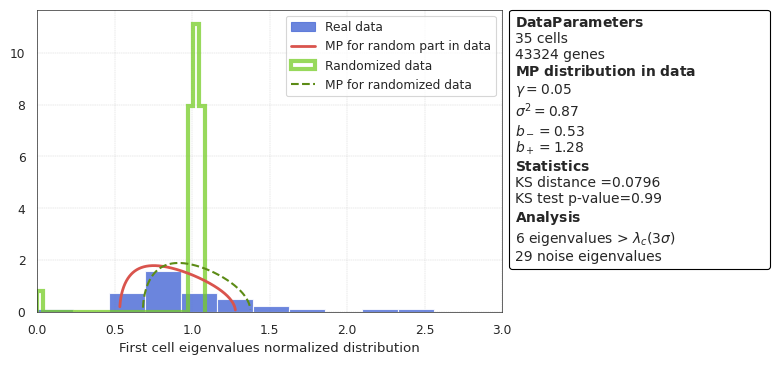

In [79]:
MC_model.plot_mp()

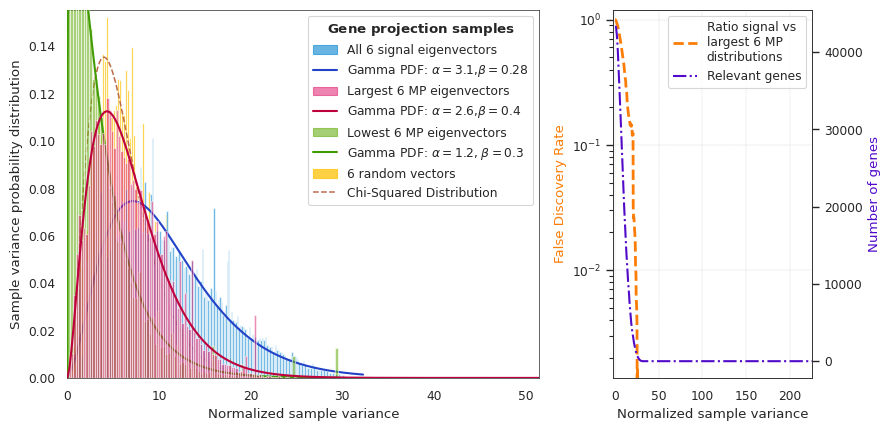

In [80]:
MC_model.plot_statistics()

In [81]:
MC_filtered = MC_model.return_cleaned(fdr=0.0001)

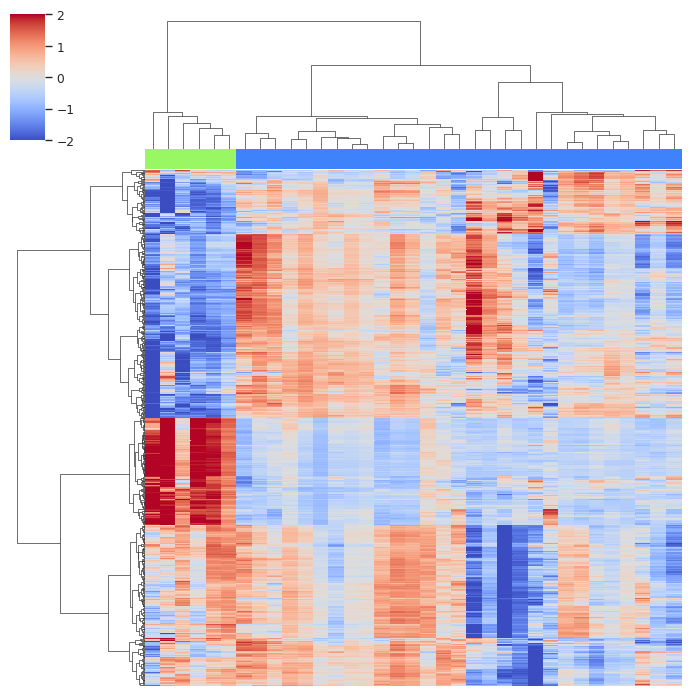

In [83]:
MC_model.fit_hierarchical()
MC_model.visual_hierarchy(thrs=100, value_range=2)

In [84]:
MC_filtered_genes = MC_filtered.T.join(gene_xloc)[['gene_short_name']]

In [85]:
MC_filtered_genes.values[:,0]

array(['PLEKHN1', 'AGRN,AL645608.5', 'PARK7', 'CA6', 'PIK3CD',
       'MIR7846,TNFRSF1B', 'EPHA2', 'SDHB', 'C1QA', 'C1QB', 'C1QC',
       'PNRC2', 'SYF2', 'TMEM50A', 'SFN', 'NR0B2', 'OPRD1', 'LAPTM5',
       'MIR6732,ZC3H12A', 'NDUFS5', 'PPT1', 'RIMKLA', 'ELAVL4', 'PIGK',
       'NEXN', 'IFI44L', 'IFI44', 'AC093155.3,HS2ST1,LINC01140', 'GBP1',
       'GBP2,GBP7', 'GBP4', 'BCAR3-AS1', 'CD53', 'ATP5PB', 'C1orf162',
       'RAP1A', 'PTPN22', 'NAP1L4P1', 'H2AC20', 'H2AC21', 'CTSS', 'CERS2',
       'PSMD4', 'CELF3', 'S100A10', 'S100A11', 'S100A6', 'S100A16',
       'SNAPIN', 'RPS27', 'C1orf43', 'UBE2Q1', 'CHRNB2', 'CKS1B',
       'LAMTOR2', 'LMNA', 'NAXE', 'CD84', 'ARHGAP30', 'UFC1', 'FCER1G',
       'SDHC', 'DDR2', 'PTPRC', 'RNPEP', 'PTPN7', 'UBE2T', 'NFASC',
       'SYT14', 'AC011700.1,PROX1-AS1', 'LINC00538', 'PROX1', 'EPRS1',
       'IARS2', 'TRIM67', 'TOMM20', 'THAP12P8', 'RGS7', 'AL592076.1',
       'AL359764.1', 'SMYD3-AS1', 'SLC66A3', 'ATRAID', 'RPL23AP34',
       'FOSL2', 'CLIP4', 